In [2]:
from rdkit import Chem
import pickle
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
import tqdm
import numpy as np
import itertools
from tabulate import tabulate

from action_utils import *

# Create dataset

start_mols = pickle.load(open("datasets/my_uspto/unique_start_mols.pickle", 'rb'))

np.random.seed(42)
indices = np.random.randint(0, start_mols.shape[0], size=(10000,))
start_mols = start_mols.iloc[indices]

main_df = pd.DataFrame(columns=["reactant", "rsub", "rcen", "rsig", "rsig_cs_indices", "psub", "pcen", "psig", "psig_cs_indices", "product"])
index = []

for smile in tqdm.tqdm(start_mols):
    mol = Chem.MolFromSmiles(smile)
    actions = get_applicable_actions(mol)
    
    for i in range(actions.shape[0]):
        product = apply_action(mol, *actions.iloc[i])
        main_df.loc[main_df.shape[0]] = [smile] + actions.iloc[i].tolist() + [Chem.MolToSmiles(product)]
        index.append(actions.iloc[i].name)
        
print(main_df.shape)

main_df.to_csv("datasets/my_uspto/supervised_zinc_gin/dataset.csv")

In [3]:
main_df = pd.read_csv("datasets/my_uspto/supervised_zinc_gin/dataset.csv", index_col=0)

In [4]:
N = 50000

# take N samples of it
np.random.seed(42)
print(main_df.shape)
elements_to_fetch = np.random.randint(0, main_df.shape[0], size=(N,))
main_df = main_df.iloc[elements_to_fetch]
print(main_df.shape)

(3976954, 10)
(50000, 10)


# Neural Network!

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

/home/abhor/miniconda3/envs/de_nono/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):


Epoch 1, Loss: 23390.2832
Epoch 2, Loss: 13377.2314
Epoch 3, Loss: 4469.2329
Epoch 4, Loss: 992.6092
Epoch 5, Loss: 388.2829
Epoch 6, Loss: 317.5132
Epoch 7, Loss: 314.5187
Epoch 8, Loss: 298.4244
Epoch 9, Loss: 305.1437
Epoch 10, Loss: 306.0251

FINAL TEST LOSS: 79.63263702392578


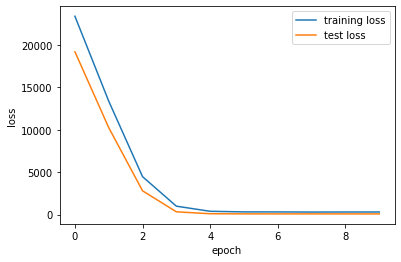

NeuralNet(
  (fc1): Linear(in_features=20, out_features=20, bias=True)
  (bn1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (hidden_layers): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (last_layer): Linear(in_features=20, out_features=1, bias=True)
)

In [6]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size, num_hidden=1, hidden_size=50):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.hidden_layers = nn.ModuleList()
        for i in range(num_hidden):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
            self.hidden_layers.append(nn.BatchNorm1d(hidden_size))
            self.hidden_layers.append(nn.ReLU())
            
        self.last_layer = nn.Linear(hidden_size, output_size)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        for layer in self.hidden_layers:
            out = layer(out)
        out = self.last_layer(out)
        return out
    

def train(X, Y, num_hidden=1, hidden_size=50, lr=1e-2, bs=64, epochs=100):
    train_X = torch.Tensor(X[:int(X.shape[0]*0.7)])
    train_Y = torch.Tensor(Y[:int(Y.shape[0]*0.7)])

    test_X = torch.Tensor(X[int(X.shape[0]*0.7):])
    test_Y = torch.Tensor(Y[int(Y.shape[0]*0.7):])
    
    model = NeuralNet(train_X.shape[1], train_Y.shape[1], num_hidden=num_hidden, hidden_size=hidden_size)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  

    loss_list = []
    test_loss = []

    # Train the model
    for epoch in range(epochs):
        for i in range(0, train_X.shape[0], batch_size):
            # Forward pass
            outputs = model(train_X[i:i+batch_size])
            loss = criterion(outputs, train_Y[i:i+batch_size])

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        loss_list.append(loss.item())
        print ('Epoch {}, Loss: {:.4f}'.format(epoch+1, loss.item()))
        
        test_loss.append(criterion(model(test_X), test_Y).item()) 
    print("\nFINAL TEST LOSS:", test_loss[-1])
        
    plt.plot(loss_list, label="training loss")
    plt.plot(test_loss, label="test loss")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()
        
    return model
        
from sklearn.datasets import make_regression
x, y = make_regression(n_samples=5000, n_features=20, noise=2, random_state=42)
y = y.reshape(-1, 1)

batch_size = 64

train(x, y, num_hidden=2, hidden_size=20, lr=1e-2, epochs=10)

# Embedding type 2 - GIN training using attribute masking on clintox

In [ ]:
from torchdrug import data

In [ ]:
model_name = "models/zinc2m_gin.pth"
clintox_gin = torch.load(model_name)

In [ ]:
def clintox_gin_mol_embedding(smiles):
    try:
        mol = data.Molecule.from_smiles(smiles, atom_feature="pretrain", bond_feature="pretrain")
        emb = clintox_gin(mol, mol.node_feature.float())["graph_feature"]
    except Exception as e:
        mol = data.Molecule.from_smiles(smiles, atom_feature="pretrain", bond_feature="pretrain", with_hydrogen=True)
        emb = clintox_gin(mol, mol.node_feature.float())["graph_feature"]
    return emb.detach().cpu()[0]

def clintox_gin_atom_embedding(smiles, idx):
    try:
        mol = data.Molecule.from_smiles(smiles, atom_feature="pretrain", bond_feature="pretrain")
        emb = clintox_gin(mol, mol.node_feature.float())["node_feature"][idx]
    except Exception as e:
        mol = data.Molecule.from_smiles(smiles, atom_feature="pretrain", bond_feature="pretrain", with_hydrogen=True)
        emb = clintox_gin(mol, mol.node_feature.float())["node_feature"][idx]
    return emb.detach().cpu()

def clinton_gin_action_embedding(action):
    rsub, rcen, rsig, _, psub, pcen, psig, __ = action
#     print(clintox_gin_mol_embedding(rsub).shape)
#     print(clintox_gin_atom_embedding(rsig, rcen).shape)
#     print(clintox_gin_mol_embedding(rsig).shape)
#     print(clintox_gin_mol_embedding(psub).shape)
#     print(clintox_gin_atom_embedding(psig, pcen).shape)
#     print(clintox_gin_mol_embedding(psig).shape)
    embedding = np.concatenate([
#                         clintox_gin_mol_embedding(rsub), 
#                         clintox_gin_atom_embedding(rsig, rcen) / 5, 
                        clintox_gin_mol_embedding(rsig), 
#                         clintox_gin_mol_embedding(psub), 
#                         clintox_gin_atom_embedding(psig, pcen) / 5, 
                        clintox_gin_mol_embedding(psig)
                    ])
    return embedding

In [38]:
X = []
for i in tqdm.tqdm(range(main_df.shape[0])):
    row = main_df.iloc[i]
    X.append(np.concatenate([clintox_gin_mol_embedding(row["reactant"]), clintox_gin_mol_embedding(row["product"])]))
X = np.stack(X)
emb_len = X.shape[1]//2
X.shape

 13%|███████▎                                                  | 6307/50000 [00:44<04:54, 148.42it/s]/home/abhor/miniconda3/envs/de_nono/lib/python3.7/site-packages/torchdrug/data/feature.py:42: UserWarning: Unknown value `Pb`
  warnings.warn("Unknown value `%s`" % x)
 14%|████████                                                  | 6998/50000 [00:49<04:55, 145.38it/s]/home/abhor/miniconda3/envs/de_nono/lib/python3.7/site-packages/torchdrug/data/feature.py:42: UserWarning: Unknown value `Li`
  warnings.warn("Unknown value `%s`" % x)
100%|█████████████████████████████████████████████████████████| 50000/50000 [05:44<00:00, 144.96it/s]


(50000, 256)

In [39]:
Y = []
for i in tqdm.tqdm(range(main_df.shape[0])):
    Y.append(clinton_gin_action_embedding(main_df.iloc[i][main_df.columns[1:-1]]))
Y = np.stack(Y)
Y.shape

100%|██████████████████████████████████████████████████████████| 50000/50000 [09:30<00:00, 87.61it/s]


(50000, 512)

/home/abhor/miniconda3/envs/de_nono/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


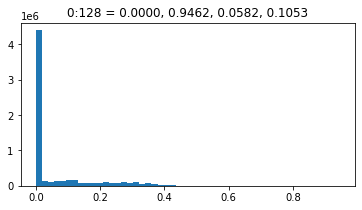

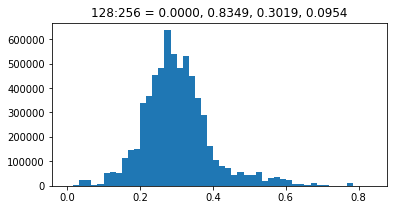

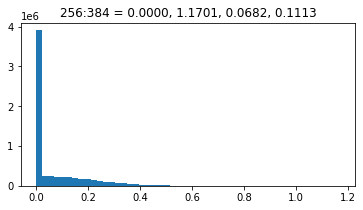

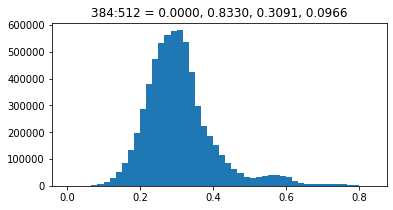

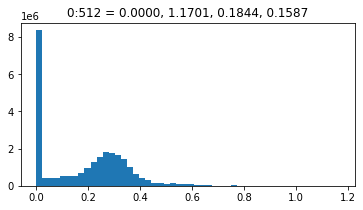

In [40]:
# for start, end in zip(np.arange(0, 511), np.arange(1, 512)):
for idx in emb_len*np.arange(5):
    start, end = idx * int(idx != emb_len*4), idx + emb_len * int(idx != emb_len*4)
    sub_Y = Y[:, start:end]
    
    plt.figure(figsize=(6, 3))
    flat = sub_Y.flatten()
    plt.hist(flat, bins=50)
    plt.title(f"{start}:{end} = {flat.min():.4f}, {flat.max():.4f}, {flat.mean():.4f}, {flat.std():.4f}")
    plt.show()

Epoch 1, Loss: 0.0045
Epoch 2, Loss: 0.0039
Epoch 3, Loss: 0.0036
Epoch 4, Loss: 0.0033
Epoch 5, Loss: 0.0030
Epoch 6, Loss: 0.0028
Epoch 7, Loss: 0.0026
Epoch 8, Loss: 0.0024
Epoch 9, Loss: 0.0022
Epoch 10, Loss: 0.0021
Epoch 11, Loss: 0.0021
Epoch 12, Loss: 0.0019
Epoch 13, Loss: 0.0020
Epoch 14, Loss: 0.0018
Epoch 15, Loss: 0.0016
Epoch 16, Loss: 0.0016
Epoch 17, Loss: 0.0014
Epoch 18, Loss: 0.0015
Epoch 19, Loss: 0.0014
Epoch 20, Loss: 0.0014
Epoch 21, Loss: 0.0013
Epoch 22, Loss: 0.0013
Epoch 23, Loss: 0.0012
Epoch 24, Loss: 0.0012
Epoch 25, Loss: 0.0012
Epoch 26, Loss: 0.0012
Epoch 27, Loss: 0.0011
Epoch 28, Loss: 0.0011
Epoch 29, Loss: 0.0011
Epoch 30, Loss: 0.0011
Epoch 31, Loss: 0.0010
Epoch 32, Loss: 0.0010
Epoch 33, Loss: 0.0010
Epoch 34, Loss: 0.0010
Epoch 35, Loss: 0.0010
Epoch 36, Loss: 0.0010
Epoch 37, Loss: 0.0009
Epoch 38, Loss: 0.0010
Epoch 39, Loss: 0.0009
Epoch 40, Loss: 0.0009
Epoch 41, Loss: 0.0009
Epoch 42, Loss: 0.0009
Epoch 43, Loss: 0.0009
Epoch 44, Loss: 0.00

/home/abhor/miniconda3/envs/de_nono/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


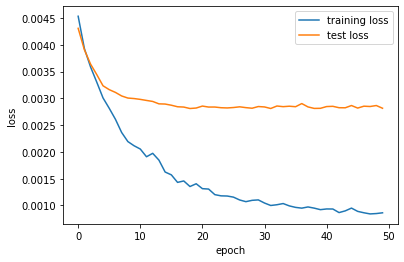

In [41]:
model = train(X, Y, hidden_size=500, num_hidden=2, lr=1e-3, epochs=50)

In [42]:
pred = model(torch.Tensor(X[40000:])).detach().numpy() 
true = Y[40000:]

for idx in emb_len*np.arange(5):
    start, end = idx * int(idx != emb_len*4), idx + emb_len * int(idx != emb_len*4)
    a = pred[:, start:end]
    b = true[:, start:end]
    print(f"{start}:{end} MSE", ((a-b)**2).mean())
#     print(f"{start}:{end} Cosine sim", ((a*b).sum(axis=1) / (a**2).sum(axis=1) / (b**2).sum(axis=1)).mean())    

0:128 MSE 0.0022778797
128:256 MSE 0.00063901086
256:384 MSE 0.007514176
384:512 MSE 0.00083669147
0:512 MSE 0.0028169414


In [43]:
embedding_file = f"datasets/my_uspto/supervised_zinc_gin/{model_name.replace('models/', '').replace('.pth', '_action_embeddings.npy')}"

try:
    action_embeddings = np.load(embedding_file)
    print("FILE EXISTS. Loading...")

except Exception as e:
    print("FILE NOT FOUND! Computing...")
    action_dataset = pd.read_csv("datasets/my_uspto/action_dataset-filtered.csv", index_col=0)

    action_dataset = action_dataset.loc[action_dataset["reactant_works"] & action_dataset["reactant_tested"] & action_dataset["action_tested"] & action_dataset["action_works"]]
    action_dataset.shape

    action_dataset = action_dataset[["rsub", "rcen", "rsig", "rbond", "psub", "pcen", "psig", "pbond"]]

    print(action_dataset.shape)

    action_embeddings = []
    for i in tqdm.tqdm(range(action_dataset.shape[0])):
        action_embeddings.append(clinton_gin_action_embedding(action_dataset.iloc[i]))
    action_embeddings = np.stack(action_embeddings)
    action_embeddings.shape
    
    print("Saving...")
    np.save(embedding_file, action_embeddings)

FILE NOT FOUND! Computing...
(88995, 8)


  7%|███▉                                                       | 6003/88995 [01:06<15:24, 89.73it/s]/home/abhor/miniconda3/envs/de_nono/lib/python3.7/site-packages/torchdrug/data/feature.py:42: UserWarning: Unknown value `K`
  warnings.warn("Unknown value `%s`" % x)
 47%|███████████████████████████▎                              | 41906/88995 [07:48<08:55, 87.88it/s]/home/abhor/miniconda3/envs/de_nono/lib/python3.7/site-packages/torchdrug/data/feature.py:42: UserWarning: Unknown value `Ga`
  warnings.warn("Unknown value `%s`" % x)
 61%|███████████████████████████████████▎                      | 54120/88995 [10:08<06:06, 95.24it/s]/home/abhor/miniconda3/envs/de_nono/lib/python3.7/site-packages/torchdrug/data/feature.py:42: UserWarning: Unknown value `As`
  warnings.warn("Unknown value `%s`" % x)
 63%|████████████████████████████████████▌                     | 56163/88995 [10:32<06:32, 83.58it/s]/home/abhor/miniconda3/envs/de_nono/lib/python3.7/site-packages/torchdrug/data/feature.py:42:

Saving...


In [44]:
correct_indices = []
action_embedding_indices = []
for i in tqdm.tqdm(range(main_df.shape[0])):
    row = main_df.iloc[i]
    applicable_actions_df = get_applicable_actions(Chem.MolFromSmiles(row["reactant"]))
    
    indices_used_for_data = np.where(action_dataset.index.isin(applicable_actions_df.index))[0]
    action_embedding_indices.append(indices_used_for_data)

    applicable_actions_df = applicable_actions_df.loc[action_dataset.iloc[indices_used_for_data].index]
    correct_indices.append((applicable_actions_df.index == row.name).argmax())
    
    assert correct_indices[-1] < len(action_embedding_indices[-1]), f"WHAT!? {correct_indices[-1]} vs {len(indices_used_for_data)}"

100%|██████████████████████████████████████████████████████████| 50000/50000 [15:36<00:00, 53.42it/s]


In [45]:
def get_ranking(pred, emb_for_comparison, correct_index, distance="euclidean", k=None):
    '''
    Get the rank of the prediction from the applicable actions.
    Returns (rank, [list_of_indices before <rank>])
    '''
    if distance == "euclidean":
        dist = ((emb_for_comparison-pred)**2).sum(axis=1)
    elif distance == "cosine":
        dist = 1 - (emb_for_comparison.dot(pred))/((emb_for_comparison**2).sum(axis=1)*(pred**2).sum())

    maxy = max(dist)

    list_of_indices = []
    for attempt in range(dist.shape[0]):
        miny = dist.argmin()
#         print(miny, correct_index, dist[correct_index], min(dist), maxy)
        if dist[miny] == dist[correct_index]:
#             print(i, attempt)
            break
        else:
            list_of_indices.append(miny)
            if k is not None and len(list_of_indices) == k:
                return list_of_indices
            dist[miny] = 100000
    
    # When the rank(correct_index) < k, then returns <rank, list>. So this extra condition - add some indices after rank(correct_index) to the list
    if k is not None:
        dist[miny] = 100000
        for attempt in range(min(k, emb_for_comparison.shape[0]-1) - len(list_of_indices)):
            miny = dist.argmin()
            list_of_indices.append(miny)
            dist[miny] = 100000
        return list_of_indices
    return attempt, list_of_indices

def get_top_k_indices(pred, emb_for_comparison, correct_index, distance="euclidean", k=1):
    return get_ranking(pred, emb_for_comparison, correct_index, distance, k)
    
    
d = {}
for idx in emb_len*np.arange(5)[]:
    l = []
    total = []
    start, end = idx * int(idx != emb_len*4), idx + emb_len * int(idx != emb_len*4)
    for i in tqdm.tqdm(range(pred.shape[0])):
        pred_for_i = pred[i]
        act_emb_for_i, correct_index = action_embeddings[action_embedding_indices[40000+i]], correct_indices[40000+i]

        pred_for_i = pred_for_i[start:end]
        act_emb_for_i = act_emb_for_i[:, start:end]

        rank, list_of_indices = get_ranking(pred_for_i, act_emb_for_i, correct_index, distance="euclidean")
        l.append(rank)
        total.append(act_emb_for_i.shape[0])
    d[f"{start}:{end}"] = l
    print(f"{start}:{end} = {np.mean(l)}({np.mean(total)}) +- {np.std(l)}  ")


100%|█████████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.57it/s]

0:512 = 506.7784(1702.4317) +- 632.6882460528566  


In [46]:
train_idx = np.arange(0, 40000)
test_idx = np.arange(40000, 50000)

In [48]:
%%time
train_X = torch.Tensor(X[train_idx])
train_Y = torch.Tensor(Y[train_idx])

test_X = torch.Tensor(X[test_idx])
test_Y = torch.Tensor(Y[test_idx])

hidden_size, num_hidden, lr, epochs, batch_size = 500, 2, 1e-3, 20, 64
model = NeuralNet(train_X.shape[1], train_Y.shape[1], num_hidden=num_hidden, hidden_size=hidden_size)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)  

# for margin, distance_metric in itertools.product([0.001, 0.003, 0.007, 0.01, 0.03, 0.07, 0.1, 0.3, 0.7, 1], ["cosine", "euclidean"]):
for margin, distance_metric in itertools.product([10009], ["euclidean"]):
    if distance_metric == "euclidean":
        criterion = nn.TripletMarginLoss(margin=margin)
    elif distance_metric == "cosine":
        criterion = nn.TripletMarginWithDistanceLoss(margin=margin, distance_function=lambda x, y: 1.0 - nn.functional.cosine_similarity(x, y))

    loss_list = []
    test_loss = []

    # Train the model
    for epoch in range(epochs):
        model.train()
        for i in range(0, train_X.shape[0], batch_size):
            # Forward pass
            outputs = model(train_X[i:i+batch_size])

            # Calc negatives
            positive_index = []
            negatives = []
            for _i in range(outputs.shape[0]):
                act_emb_for_i, correct_index = action_embeddings[action_embedding_indices[train_idx[i+_i]]], correct_indices[train_idx[i+_i]]
                top = get_top_k_indices(outputs[_i].detach().cpu().numpy(), act_emb_for_i, correct_index, distance=distance_metric, k=50)

                positive_index.extend([_i]*len(top))
                negatives.append(act_emb_for_i[top])
            negatives = np.concatenate(negatives, axis=0)
            
            # Calc loss
            loss = criterion(outputs[positive_index], train_Y[i:i+batch_size][positive_index], torch.Tensor(negatives))

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_list.append(loss.item())
        print ('{:.6f}({})'.format(loss.item(), epoch+1), end='  ')
        
        # SWITCH INDENT HERE ----
        model.eval()
        with torch.no_grad():
            print()

            margin_string = f"# Margin = {margin} | distance_metric = {distance_metric} | topk distance = {distance_metric} #"
            print("#" * len(margin_string))
            print(margin_string)
            print("#" * len(margin_string))

            # Predictions and action component-wise loss
            pred = model(test_X).detach().numpy() 
            true = test_Y.detach().numpy()

            metric_df = pd.DataFrame(columns=["MSE", "Cosine", "Rank(euclid)", "Rank(cosine)"])

            # Print Test metrics
            mse_list = []
            cosine_list = []
            idx_list = []
            for idx in emb_len*np.arange(5):
                start, end = idx * int(idx != emb_len*4), idx + emb_len * int(idx != emb_len*4)
                a = pred[:, start:end]
                b = true[:, start:end]
                mse_list.append(((a-b)**2).sum() / np.prod(a.shape))
                cosine_list.append(((a*b).sum(axis=1) / (a**2).sum(axis=1) / (b**2).sum(axis=1)).mean())    
                idx_list.append(f"{start}:{end}")

            # Print Test metric - Rank
            d = {}
            for dist in ["euclidean", "cosine"]:
                rank_list = []
                for idx in emb_len*np.arange(5):
                    l = []
                    total = []
                    start, end = idx * int(idx != emb_len*4), idx + emb_len * int(idx != emb_len*4)
                    for i in range(100):#tqdm.tqdm(range(pred.shape[0])):
                        pred_for_i = pred[i]
                        act_emb_for_i, correct_index = action_embeddings[action_embedding_indices[test_idx[i]]], correct_indices[test_idx[i]]

                        pred_for_i = pred_for_i[start:end]
                        act_emb_for_i = act_emb_for_i[:, start:end]

                        rank, list_of_indices = get_ranking(pred_for_i, act_emb_for_i, correct_index, distance=dist)
                        l.append(rank)
                        total.append(act_emb_for_i.shape[0])
        #             print(f"{start}:{end} = {np.mean(l)}({np.mean(total)}) +- {np.std(l)}  ")
                    rank_list.append(f"{np.mean(l):.4f}({np.mean(total)}) +- {np.std(l):.4f}")
                d[dist] = rank_list

            metric_df["MSE"] = mse_list
            metric_df["Cosine"] = cosine_list
            metric_df["Rank(euclid)"] = d["euclidean"]
            metric_df["Rank(cosine)"] = d["cosine"]
            metric_df.index = idx_list
            print(tabulate(metric_df, headers='keys', tablefmt='fancy_grid'))
            print()

0.014388(1)  
############################################################################
# Margin = 0.01 | triplet_distance = euclidean | topk distance = euclidean #
############################################################################
╒═════════╤═══════════╤══════════════╤═══════════════════════════════╤═══════════════════════════════╕
│         │       MSE │       Cosine │ Rank(euclid)                  │ Rank(cosine)                  │
╞═════════╪═══════════╪══════════════╪═══════════════════════════════╪═══════════════════════════════╡
│ 0:128   │ 42.0818   │  0.000484974 │ 224.3100(1674.35) +- 539.5896 │ 246.0900(1674.35) +- 574.5390 │
├─────────┼───────────┼──────────────┼───────────────────────────────┼───────────────────────────────┤
│ 128:256 │ 70.8538   │ -0.0006369   │ 236.2100(1674.35) +- 573.3608 │ 186.2100(1674.35) +- 514.6124 │
├─────────┼───────────┼──────────────┼───────────────────────────────┼───────────────────────────────┤
│ 256:384 │  0.112924 │  0.0580859

╒═════════╤═══════════╤══════════════╤═══════════════════════════════╤═══════════════════════════════╕
│         │       MSE │       Cosine │ Rank(euclid)                  │ Rank(cosine)                  │
╞═════════╪═══════════╪══════════════╪═══════════════════════════════╪═══════════════════════════════╡
│ 0:128   │ 67.1277   │  0.00115354  │ 165.0800(1674.35) +- 324.0521 │ 186.3400(1674.35) +- 434.2714 │
├─────────┼───────────┼──────────────┼───────────────────────────────┼───────────────────────────────┤
│ 128:256 │ 87.9087   │ -0.000392768 │ 236.0300(1674.35) +- 615.0132 │ 171.4100(1674.35) +- 569.9561 │
├─────────┼───────────┼──────────────┼───────────────────────────────┼───────────────────────────────┤
│ 256:384 │  0.623436 │  0.0142878   │ 279.9400(1674.35) +- 353.5683 │ 452.9100(1674.35) +- 530.9072 │
├─────────┼───────────┼──────────────┼───────────────────────────────┼───────────────────────────────┤
│ 384:512 │  2.15218  │  0.00482524  │ 175.1700(1674.35) +- 321.5645 │ 27

0.002259(12)  
############################################################################
# Margin = 0.01 | triplet_distance = euclidean | topk distance = euclidean #
############################################################################
╒═════════╤══════════╤══════════════╤═══════════════════════════════╤═══════════════════════════════╕
│         │      MSE │       Cosine │ Rank(euclid)                  │ Rank(cosine)                  │
╞═════════╪══════════╪══════════════╪═══════════════════════════════╪═══════════════════════════════╡
│ 0:128   │ 11.656   │  0.0041792   │ 238.0700(1674.35) +- 568.7443 │ 229.0300(1674.35) +- 611.4758 │
├─────────┼──────────┼──────────────┼───────────────────────────────┼───────────────────────────────┤
│ 128:256 │ 17.2886  │ -9.02738e-06 │ 177.2400(1674.35) +- 388.9735 │ 105.7200(1674.35) +- 337.5203 │
├─────────┼──────────┼──────────────┼───────────────────────────────┼───────────────────────────────┤
│ 256:384 │  1.20259 │  0.00590278  │ 30

0.001029(18)  
############################################################################
# Margin = 0.01 | triplet_distance = euclidean | topk distance = euclidean #
############################################################################
╒═════════╤═════════╤═════════════╤═══════════════════════════════╤═══════════════════════════════╕
│         │     MSE │      Cosine │ Rank(euclid)                  │ Rank(cosine)                  │
╞═════════╪═════════╪═════════════╪═══════════════════════════════╪═══════════════════════════════╡
│ 0:128   │ 4.14219 │ 0.00463659  │ 266.4700(1674.35) +- 562.3223 │ 166.2800(1674.35) +- 511.6741 │
├─────────┼─────────┼─────────────┼───────────────────────────────┼───────────────────────────────┤
│ 128:256 │ 7.0698  │ 0.000272117 │ 318.2400(1674.35) +- 630.1493 │ 126.9200(1674.35) +- 498.2459 │
├─────────┼─────────┼─────────────┼───────────────────────────────┼───────────────────────────────┤
│ 256:384 │ 1.49044 │ 0.00400144  │ 344.2200(1674.35) 

# Visualisations

# TSNE over the embeddings...
import matplotlib.pyplot as plt
from sklearn import manifold, datasets

def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)

def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(7, 7), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()

n_samples = 1500
n_components = 2
S_points, S_color = datasets.make_s_curve(n_samples, random_state=0)

t_sne = manifold.TSNE(
    n_components=n_components,
    perplexity=30,
    init="random",
    n_iter=250,
    random_state=0,
)
S_t_sne = t_sne.fit_transform(S_points)

plot_2d(S_t_sne, S_color, "T-distributed Stochastic  \n Neighbor Embedding")

from rewards.properties import logP

start_mols = pickle.load(open("datasets/my_uspto/unique_start_mols.pickle", 'rb'))

np.random.seed(42)
indices = np.random.randint(0, start_mols.shape[0], size=(10000,))
start_mols = start_mols.iloc[indices]
print(start_mols.shape)

mol_emb = np.stack(list(map(clintox_gin_mol_embedding, start_mols)))
logp_list = np.array(list(map(lambda x: logP(Chem.MolFromSmiles(x)), start_mols)))

print(mol_emb.shape, logp_list.shape)

mean = logp_list.mean()
std = logp_list.std()

mol_emb = mol_emb[(logp_list < mean+1*std) & (logp_list > mean-1*std)]
logp_list = logp_list[(logp_list < mean+1*std) & (logp_list > mean-1*std)]

print(mol_emb.shape, logp_list.shape)

for i in range(1, 50):
    t_sne = manifold.TSNE(
        n_components=n_components,
        perplexity=i,
        init="random",
        n_iter=250,
        random_state=0,
    )
    S_t_sne = t_sne.fit_transform(mol_emb)

    plot_2d(S_t_sne, logp_list, f"T-distributed Stochastic  \n Neighbor Embedding (perplexity = {i})")
    plt.show()